# Прогнозирование спроса товаров собственного производства для "Ленты"


### Описание задачи

Необходимо создать алгоритм прогноза спроса в штуках на 14 дней для товаров собственного производства (кухня, пекарня и пр.). Гранулярность ТК-SKU-День.

Термины:

ТК - Торговый комплекс

SKU – Товар

СП - собственное производство

Прогноз позволит повысить доступность и продажи в ТК, без повышения списаний и повышение маржинальности. При изготовлении товаров СП сотрудники будут ориентироваться не на экспертный подход, а на ML прогноз спроса, в соответствии с которым будут изготавливать продукцию и планировать заказы сырья.

### Метрика

WAPE

Формула:

def wape(y_true: np.array, y_pred: np.array):

return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

### Описание данных

1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

     * *st_id* – захэшированное id магазина;
     * *pr_sku_id* – захэшированное id товара;
     * *date* – дата;
     * *pr_sales_type_id* – флаг наличия промо;
     * *pr_sales_in_units* – число проданных товаров без признака промо;
     * *pr_promo_sales_in_units* – число проданных товаров с признаком промо;
     * *pr_sales_in_rub* – продажи без признака промо в РУБ;
     * *pr_promo_sales_in_rub* – продажи с признаком промо в РУБ;

2. **pr_df.csv** – данные по товарной иерархии.

    * *pr_group_id* – захэшированная группа товара;
    * *pr_cat_id* – захэшированная категория товара;
    * *pr_subcat_id* – захэшированная подкатегория товара;
    * *pr_sku_id* – захэшированное id товара;
    * *pr_uom_id* (маркер, обозначающий продаётся товар на вес или в ШТ).
    
3. **pr_st.csv** – данные по магазинам.

    * *st_id* – захэшированное id магазина;
    * *st_city_id* – захэшированное id города;
    * *st_division_code id* – захэшированное id дивизиона;
    * *st_type_format_id* – id формата магазина;
    * *st_type_loc_id* – id тип локации/окружения магазина;
    * *st_type_size_id* – id типа размера магазина;
    * *st_is_active* – флаг активного магазина на данный момент.



## Первичное ознакомление с данными

In [ ]:
# Установка необходимых библиотек
!pip install statsmodels --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install --upgrade tables --quiet
!pip install blosc2~=2.2.8 --quiet
!pip install pmdarima --quiet
!pip install phik==0.10.0 --quiet
!pip install calmap --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import phik
import calmap
import pickle
import statsmodels.api as sm

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from phik.report import plot_correlation_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

Используемые функции

In [ ]:
# Построение графика изменения продаж товаров в штуках с рампределением по месяцам
def plot_cat_sales(data, name,  date, column1, column2, column3):

    df = data[data[column1] == name][[date, column2, column3]]
    df[date] = pd.to_datetime(df[date])
    df.set_index(date, inplace=True)
    pivot_table = df.pivot_table(index=df.index.month, columns=column2, values=column3, aggfunc='sum')

    plt.figure(figsize=(15, 5))

    sns.lineplot(data=pivot_table)
    plt.legend(loc='upper left')
    plt.xlabel('Месяц')
    plt.ylabel('Количество товара')
    plt.title(f'Изменение продаж товаров {name} группы по категориям по месяцам')
    plt.show()


# Установка даты в качестве индекса для создаваемых срезов таблицы при анализе
def set_date_index(input_df, col_name='date'):

    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.set_index(col_name, inplace=True)

    return modified_df


# Подсчет строк с отрицательными значениями в столбце
def neg_val(data, column):
    count = len(data[data[column] < 0])

    return count

# Расчет WAPE
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

# Функция для получения предсказаний и подготовки результатов к пролучению предсказаний мета-модели
def predict_model_1st_level(df, all_models):

    df = generate_features(df)

    features_df = df.drop(['pr_sales_in_units', 'pr_promo_sales_in_units','pr_sales_in_rub', 'pr_promo_sales_in_rub'], axis=1)
    target_df = df['pr_sales_in_units']

    meta_feat = []
    for model in all_models:
        y_pred = model.predict(features_df)
        meta_feat.append(y_pred)

    meta_feat_array = np.array(meta_feat, dtype=np.float32).T.reshape(-1, len(meta_feat))
    target_valid_array = target_df.values.astype(np.float32).reshape(-1, 1)

    return meta_feat_array, target_valid_array, features_df, target_df

# Построение графиков остаточного анализа
def residual_plot(df):
    # Вычисление остатков
    residuals = df['prediction'] - df['target']

    # Стандартизация остатков
    standardized_residuals = ((residuals - residuals.mean()) / residuals.std()).astype(np.float32)

    residuals = residuals.astype(np.float32)

    # Создание графиков 2x2
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))

    ax[0, 0].plot(residuals)
    ax[0, 0].axhline(residuals.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(standardized_residuals, title='Correlogram', ax=ax[0, 1])

    sm.qqplot(residuals, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(residuals.min(), residuals.max(), 1000)
    norm = stats.norm(loc=0, scale=residuals.std())
    ax[1, 1].hist(residuals, bins=30, label='histogram', density=True)
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

Загрузим исходные данные и выведем первичную информацию о данных.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Открываем файлы

names = ['sales_df_train', 'pr_df', 'st_df', 'holidays_covid_calendar']

for n in names:
  try:
    globals()[n] = pd.read_csv(f'{n}.csv')

  except:
    globals()[n] = pd.read_csv(f'/content/drive/MyDrive/Lenta_Hackaton/{n}.csv')

In [ ]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [ ]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [ ]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes


В датафрейме train присутствует столбец date, содержащий дату продажи. Его необходимо привести к соответствующему типу данных

In [ ]:
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])

Для получения полной информации о данных необходимо обьединить исходные датафреймы в один. Обьединение возможно по столбцам pr_sku_id и st_id.

In [ ]:
temp_df = pd.merge(sales_df_train, pr_df, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

В данных присутствуют громоздкие захэшированные названия, которые при анализе будут крайне неудобны. Закодируем их числами.

In [ ]:
hash_to_num_dict = {}
num_to_hash_dict = {}

for column in df.columns:
    if df[column].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        unique_values = df[column].unique()
        hash_to_num = {value: num for num, value in enumerate(unique_values)}
        num_to_hash = {num: value for num, value in enumerate(unique_values)}
        hash_to_num_dict[column] = hash_to_num
        num_to_hash_dict[column] = num_to_hash

# 2. Замена хэшей на порядковые номера в df
df_num = df.copy()
for column, hash_to_num in hash_to_num_dict.items():
    df_num[column] = df[column].map(hash_to_num)

Выведем размеры полученного датафрейма, проверим на наличие явных дубликатов и выведем информацию о содержащихся в нем данных.

In [ ]:
print('Размер датафрейма:', df_num.shape)
print('Количество явных дубликатов:', df_num.duplicated().sum())

Размер датафрейма: (883015, 18)
Количество явных дубликатов: 0


In [ ]:
df_num.describe()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,883015.000000,883015.00000,883015,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,2.643212,464.05628,2023-01-25 18:19:37.852697856,0.406486,5.037956,2.230010,596.705181,294.766561,1.095535,6.692289,35.464480,6.751821,1.653929,1.389358,1.096438,1.206916,11.464332,0.999174
min,0.000000,0.00000,2022-08-01 00:00:00,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000
25%,1.000000,131.00000,2022-10-29 00:00:00,0.000000,1.000000,0.000000,98.000000,0.000000,0.000000,3.000000,13.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,1.000000
50%,2.000000,302.00000,2023-01-27 00:00:00,0.000000,2.000000,0.000000,224.000000,0.000000,1.000000,4.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000
75%,4.000000,575.00000,2023-04-25 00:00:00,1.000000,4.000000,1.000000,540.000000,127.000000,1.000000,8.000000,52.000000,17.000000,3.000000,2.000000,1.000000,1.000000,12.000000,1.000000
max,11.000000,1990.00000,2023-07-18 00:00:00,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,8.000000,42.000000,166.000000,17.000000,6.000000,5.000000,4.000000,3.000000,32.000000,1.000000
std,1.995685,473.29908,NaN,0.491178,13.402984,11.063288,1577.366179,1402.764168,1.208619,6.181867,27.492739,7.677614,1.428024,1.089772,0.415505,0.438867,4.509462,0.028721


Из информации по таблице мы видим, что в данных присутствуют отрицательные значения в столбцах 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub' и 'pr_promo_sales_in_rub'. Подсчетаем количество строк с такими значениями.

In [ ]:
# Подсчет строк в столбцах с отрицательным значением
negative_column = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']

for col in negative_column:
    print(f'Количество строк с отрицательным значением в столбце {col}:', neg_val(df_num, col))

Количество строк с отрицательным значением в столбце pr_sales_in_units: 71
Количество строк с отрицательным значением в столбце pr_promo_sales_in_units: 35
Количество строк с отрицательным значением в столбце pr_sales_in_rub: 78
Количество строк с отрицательным значением в столбце pr_promo_sales_in_rub: 36


Таких строк не очень много, скорее всего это возвраты товаров. поэтому лучше их просто исключить из дальнейшего анализа.

In [ ]:
df_num = df_num.loc[(df_num['pr_sales_in_units'] >= 0) & (df_num['pr_promo_sales_in_units'] >= 0)
                    & (df_num['pr_sales_in_rub'] >= 0) & (df_num['pr_promo_sales_in_rub'] >= 0)]

**Вывод:**
1. Данные представлены в 3 таблицах, которые  были соединены в единую таблицу.
2. Итоговый датафрейм содержит 883015 строк и 18 столбцов.
3. Столбец date содержит информацию о датах продаж, поэтому был приведен к формату datetime.
4. В некоторых столбцах содержится захэшированная информация, которая при визуализации и изучении данных будет неудобна. Поэтому был создан словарь с хэшированными данными и присвоенными им числами.
5. При первичном ознакомлении с данными пропусков не было обнаружено, но в данных присутствует небольшое количество отрицательных значений. Поскольку нам предоставлены данные о продажах, то отрицательные значения могли возникнуть по нескольким причинами: возврат товар, списание товара или ошибка при выгрузке данных. Такие данные решили исключить из анализа, поскольку количество таких позиций небольшое, а природа происхождения не ясна.

# EDA

Посмотрим на распределение целевого признака по категориальным признакам в датафрейме.

In [ ]:
# Создание списка категориальных признаков
cat_cols = ['st_id', 'pr_sales_type_id', 'pr_group_id', 'pr_cat_id',
            'pr_uom_id', 'st_city_id', 'st_division_code',
            'st_type_format_id', 'st_type_loc_id', 'st_type_size_id',
            'st_is_active']

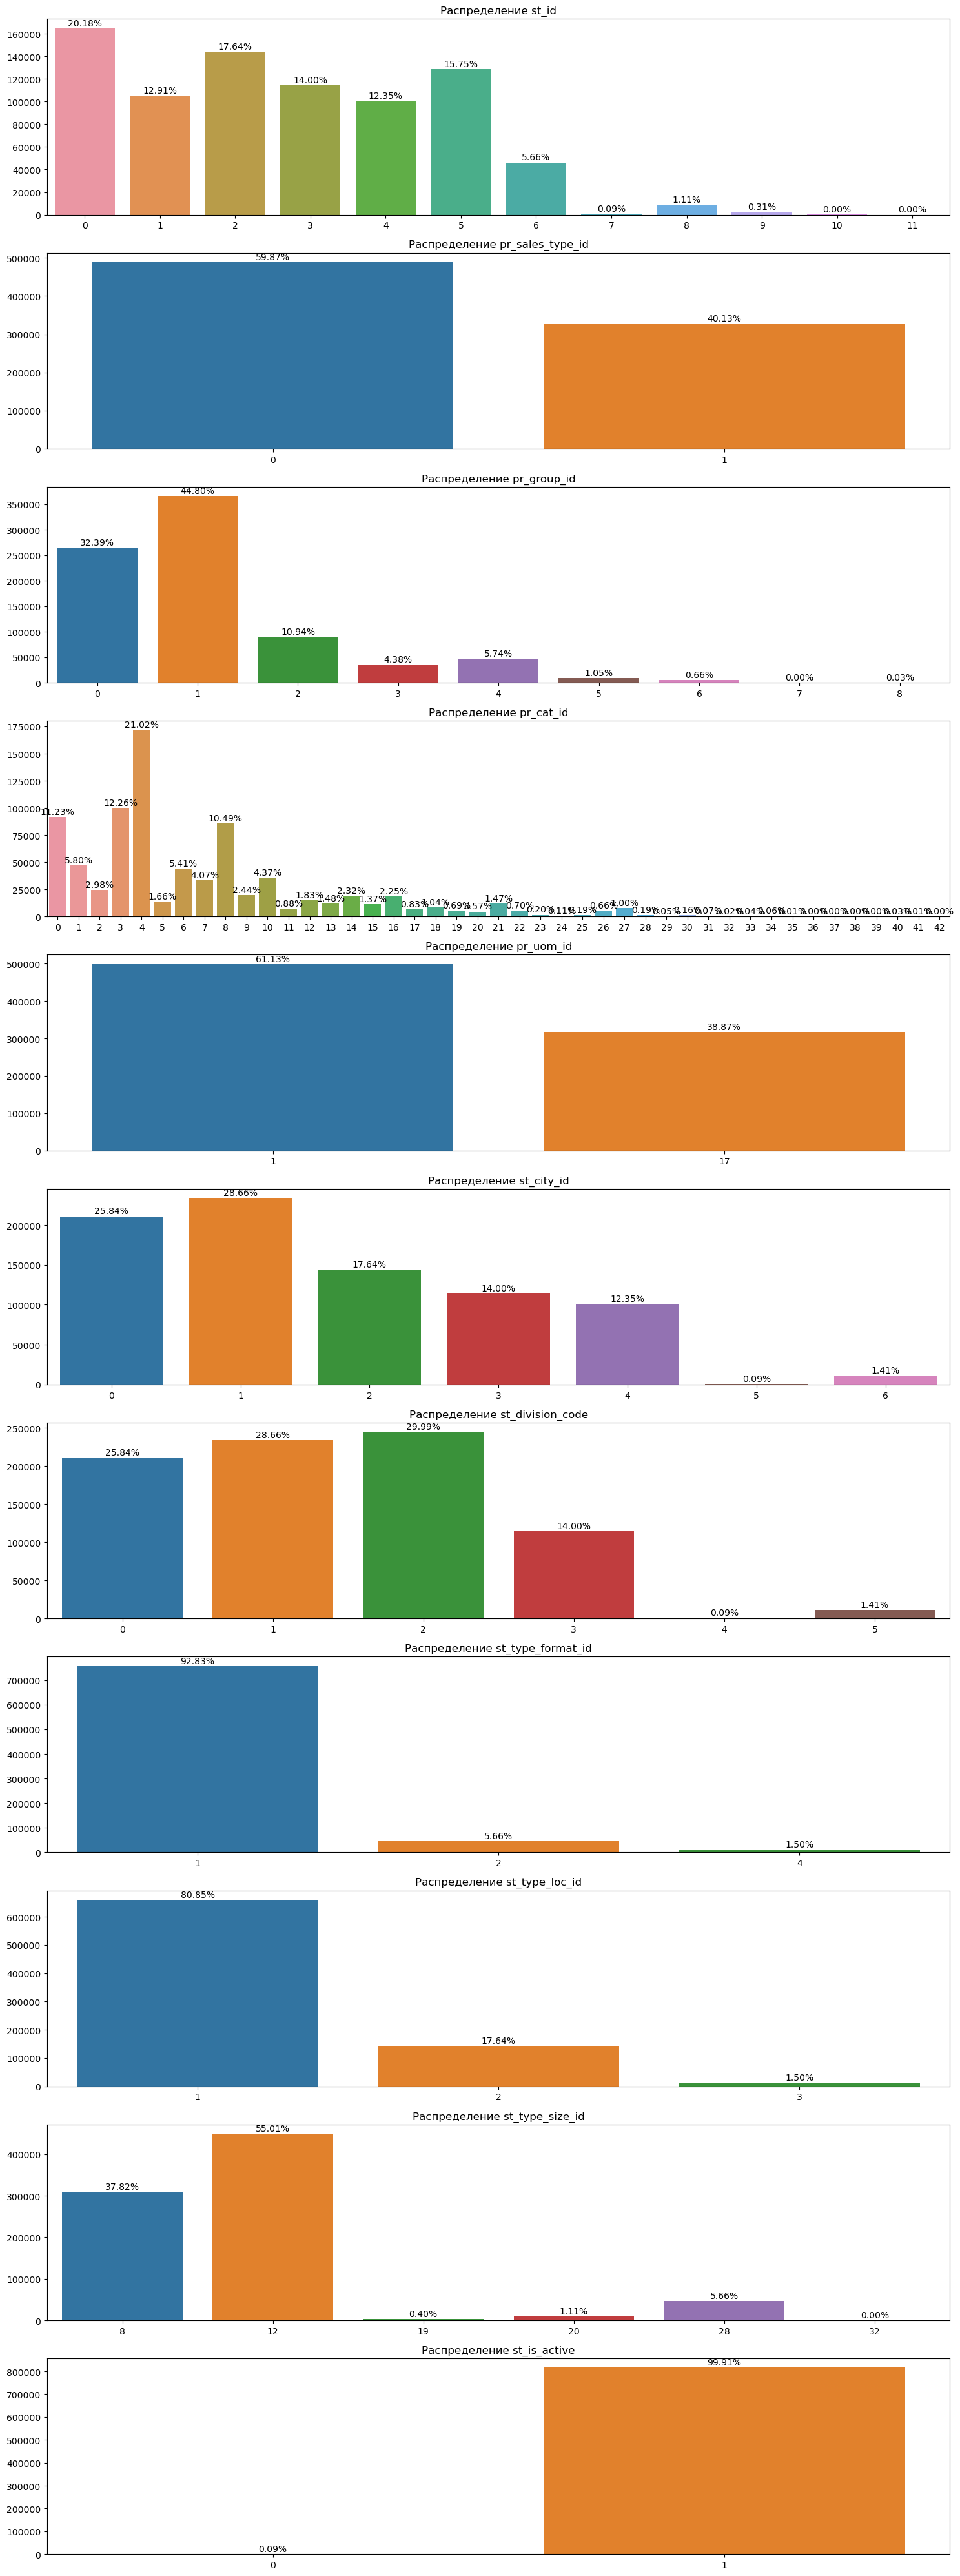

In [ ]:
cols = 1
rows = len(cat_cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df_num, x=col, ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.set(xlabel=None, ylabel=None)

    total = len(df_num)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

На основе графиков можно сделать следующие выводы:

1. В группировке товаров можно выделить топ-3:
      * Группа №1 - 44,8%
      * Группа №0 - 32,39%
      * Группа №2 - 10.94%
      
      
2. В нашем распоряжении данные 12 магазинов. Очень мало данных о магазинах с номером 7, 9, 10 и 11. Продажи этих магазинов составляют менее 1% от общего обьема данных.


3. Среди категорий товара также можно выделить топ наиболее продаваемых категорий:
     * Категория №4 - 21.02%
     * Категория №3 - 12.26%
     * Категория №0 - 11.23%
     * Категория №8 - 10.49%
     
4. Магазины располагаются в 7 городах.


5. В столбце st_is_active представлена информаци о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никаой смысловой информации для нас.

6. Доля данных со значением 32 в столбце st_type_size_id  практически равна нулю.

На графиках видны магазин с малым количеством данных. Это магазины 7, 9, 10 и 11. Возмжно их только недавно открыли.

Соберем информацию о каждом магазине: его продажах, уникальных товаров, наиболее популярных товарах, дивизионе магазина, формате, городе, типе локации и размере.

In [ ]:
unique_sku_by_store = {}

df_grouped = df_num.groupby('st_id')

for store_id, df_store in df_grouped:
    pr_sku_id_store = df_store['pr_sku_id'].unique()
    unique_sku_id = []

    for pr in pr_sku_id_store:
        num = len(df_grouped.get_group(store_id).query('pr_sku_id == @pr'))
        if num == 1:
            unique_sku_id.append(pr)

    store_name = df_store['st_id'].iloc[0]
    first_sale_date = df_store['date'].min()
    last_sale_date = df_store['date'].max()
    total_sales = round(df_store['pr_sales_in_rub'].sum(), 2)
    popular_items = df_store.groupby(['pr_cat_id', 'pr_sku_id']).agg({'pr_sales_in_units': 'sum', 'pr_sales_in_rub': 'sum'}).nlargest(5, 'pr_sales_in_units')
    percent_unique_sku = round(len(unique_sku_id) / len(pr_sku_id_store) * 100, 2)
    sity_name = df_store['st_city_id'].unique()
    store_division_id = df_store['st_division_code'].unique()
    form_store = df_store['st_type_format_id'].unique()
    type_loc_store = df_store['st_type_loc_id'].unique()
    type_size_store = df_store['st_type_size_id'].unique()


    unique_sku_by_store[store_id] = {
        'Наименование магазина': store_name,
        'Город': sity_name,
        'Дивизион магазина': store_division_id,
        'Формат магазина': form_store,
        'Тип локации/окружения магазина': type_loc_store,
        'Тип размера магазина': type_size_store,
        'Дата первой продажи': first_sale_date,
        'Дата последней продажи': last_sale_date,
        'Уникальные позиции магазина': unique_sku_id,
        'Сумма продаж за все время': total_sales,
        'Процент уникальных товаров': percent_unique_sku,
        'Наиболее популярные товары': popular_items,
    }

for store_id, store_data in unique_sku_by_store.items():
    print('*'*100)
    print(f"Store ID: {store_id}")
    for key, value in store_data.items():
        print(f"{key}: {value}")
    print('*'*100)
    print()

****************************************************************************************************
Store ID: 0
Наименование магазина: 0
Город: [0]
Дивизион магазина: [0]
Формат магазина: [1]
Тип локации/окружения магазина: [1]
Тип размера магазина: [8]
Дата первой продажи: 2022-08-01 00:00:00
Дата последней продажи: 2023-07-18 00:00:00
Уникальные позиции магазина: [340, 597, 625, 765, 777, 801, 806, 839, 857, 902, 934, 940, 977, 984, 990, 1009, 1017, 1031, 1039, 1046, 1053, 1054, 1061, 1062, 1068, 1071, 1078, 1079, 1081, 1084]
Сумма продаж за все время: 109380512.82
Процент уникальных товаров: 2.79
Наиболее популярные товары:                      pr_sales_in_units  pr_sales_in_rub
pr_cat_id pr_sku_id                                    
4         45                   42088.0        1999391.0
          532                  27146.0        1546101.0
          43                   22350.0         335688.0
10        196                  19296.0        2362788.0
9         70                

* У большинства магазинов есть свои уникальные товары, которые продаются, то в этих магазинах. Исключением являются магазины 7 и 11.

* Магазин с id 10 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся, поэтому информации по нему крайне мало. Исключать этот магазин из анализа не будем, поскольку в этом городе этот магазин не единственный.  

* Магазин с id 7 представил данные ровно за 1 месяц - август 2022 года. Обьем продаж крайне мал, поэтому этот магазин мы исключаем из дальнейшего анализа.

* Данные магазина с id 11 также не информативны, поскольку он осуществлял продажи только в период с 24 августа по 8 сентября 2022, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции. Поэтому этот магазин тоже необходимо исключить.


Также на графиках видно, что у нас представлено очень маленькое количество товаров 7 и 8 группы. Такие группы следует исключить из дальнейшего исследования.

Исключим данные, которые было решено убрать.

In [ ]:
df_num = df_num.query('st_id != (7, 11)')
df_num = df_num.query('pr_group_id != (7, 8)')
df_num = df_num.query('st_is_active != 0')
df_num = df_num.drop('st_is_active', axis=1)

Посмотрим на распределение продаж в штуках во времени.

In [ ]:
# Создание среза таблицы для просмотра общих продаж в штуках во времени
df_a = df_num[['date', 'pr_sales_in_units']]
df_a = set_date_index(df_a, 'date')
df_a = df_a.resample('1d').sum()

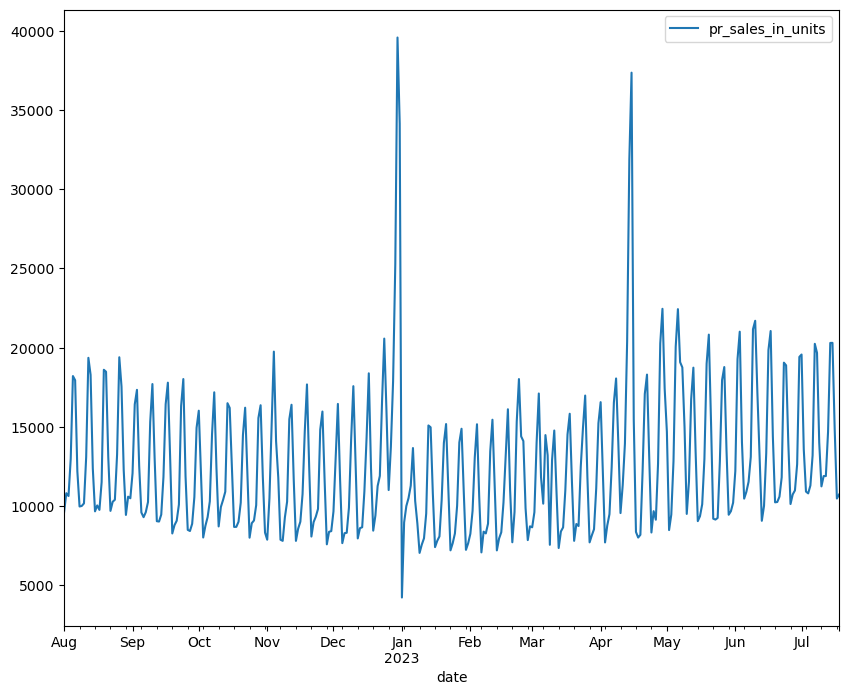

In [ ]:
# Вывод графика распределения общих продаж
df_a.plot(figsize=(10, 8))
plt.show()

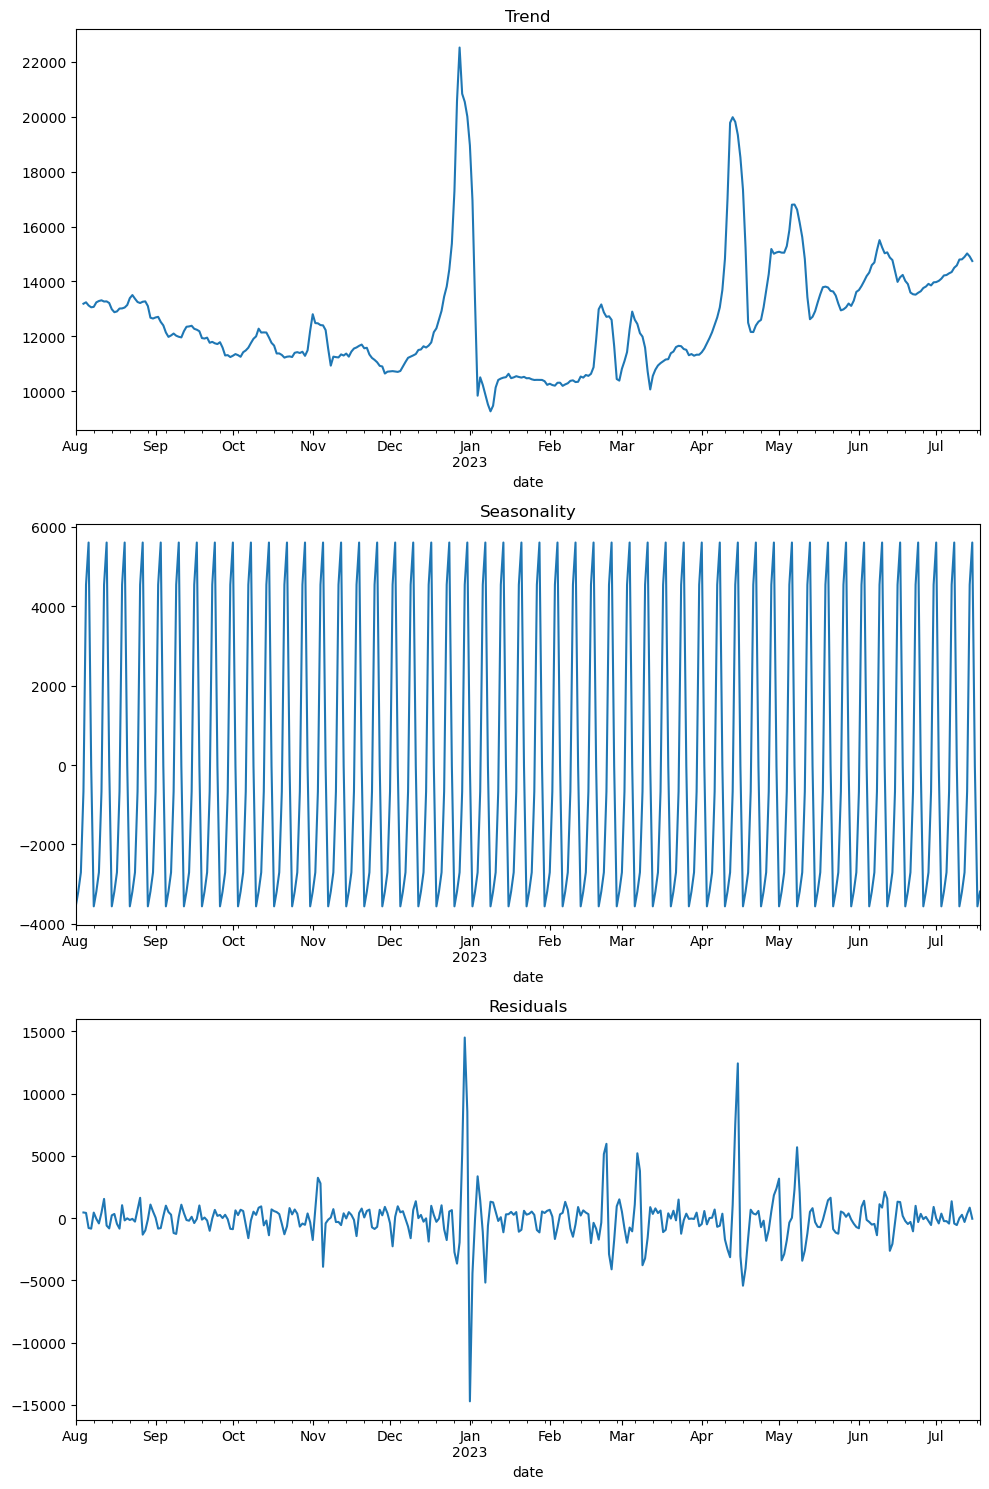

In [ ]:
# Визуализация трендов,сезонности общих продаж во времени
decomposed = seasonal_decompose(df_a)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По полученным графикам видно, что в конце декабря имеется очень большой скачок продаж, а потом резкое падение. Такой подьем продаж можно объяснить тем, что происходит празднование Нового года. А вот падение приходится на начало января. Это может быть связано со списанием товаров с ограниченным сроком годности.


В целом на графике с трендами видны всплески продаж в период праздников. Например,  в конце февраля - начале марта (23 февраля, 8 марта, масленица) или апрель - май (пасха, 1 мая, 9 мая). Самый низкий тред продаж на графике - это январь-февраль, самый высокий декабрь.

Посмотрим распределение продаж за последние две недели в данных, т.к. график сезонности был не очень информативен.

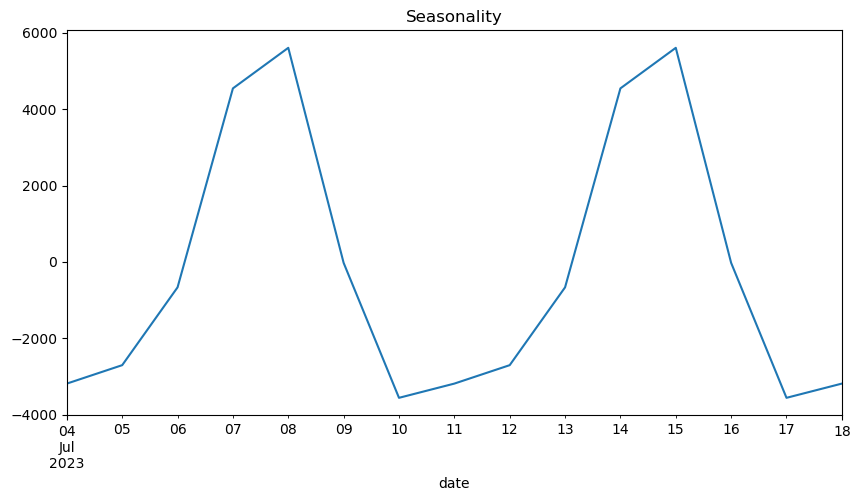

In [ ]:
plt.figure(figsize=(10, 5))
decomposed.seasonal['2023-07-04':'2023-07-18'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Исходя из графика можно сделать выводы, что пик продаж приходится на выходные дни, а вот в понедельник происходит резкое падение продаж до минимума.

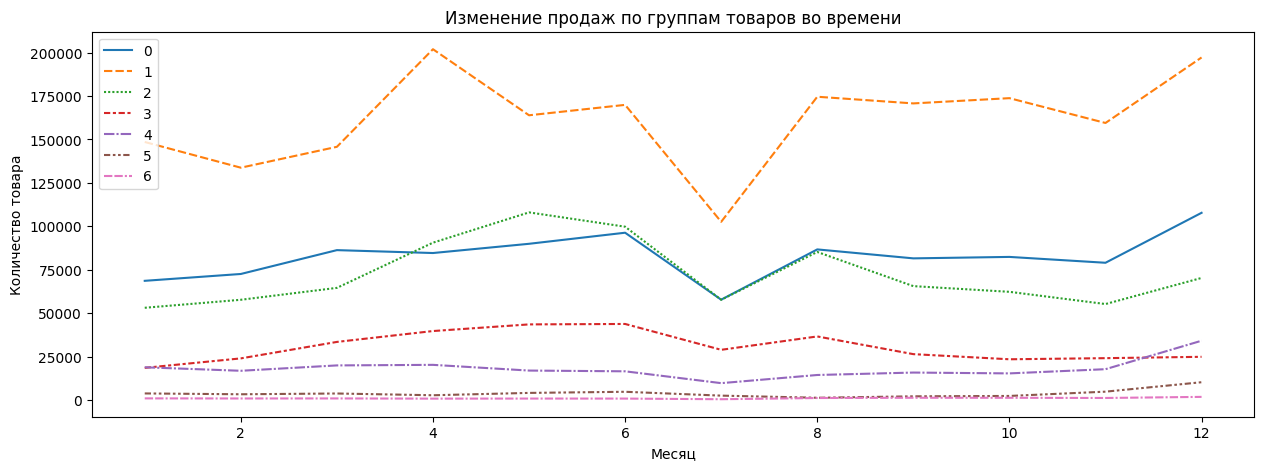

In [ ]:
#  Визуализация распределения общих продаж каждой группы товаров во времени
df_plot = df_num[['date', 'pr_group_id', 'pr_sales_in_units']].copy()
df_plot = set_date_index(df_plot, 'date')
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='pr_group_id', values='pr_sales_in_units', aggfunc='sum')


plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Количество товара')
plt.title('Изменение продаж по группам товаров во времени')

plt.show()

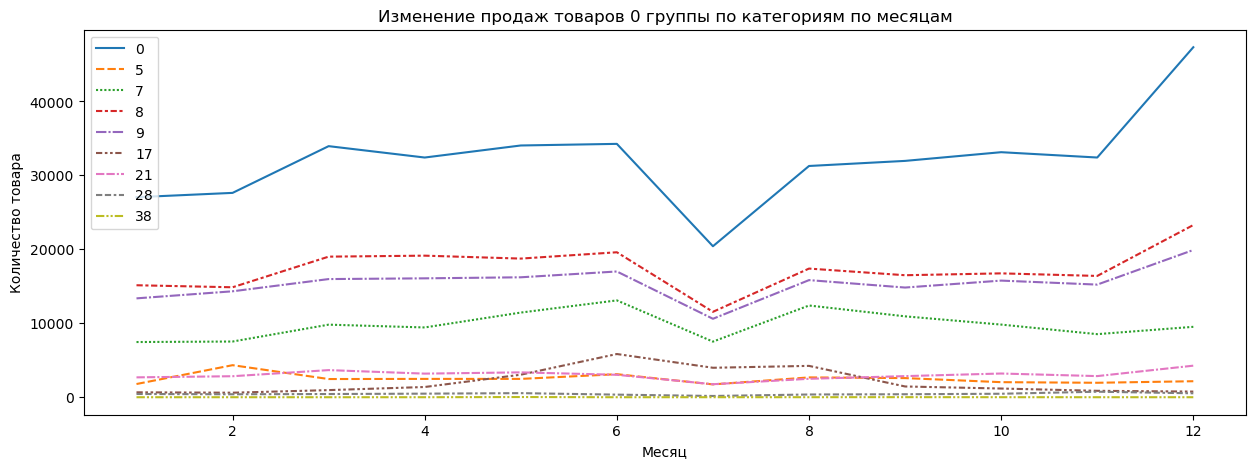

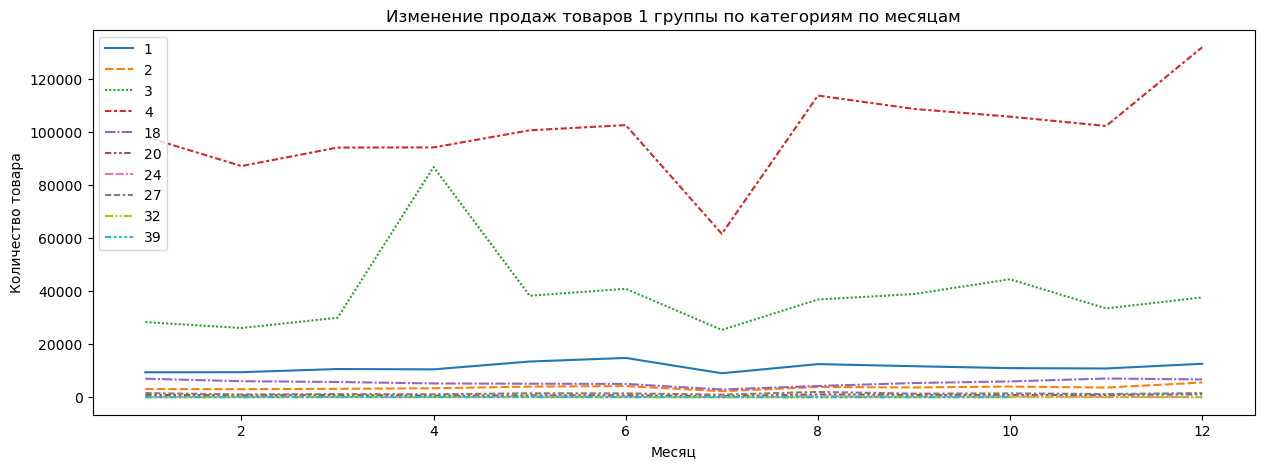

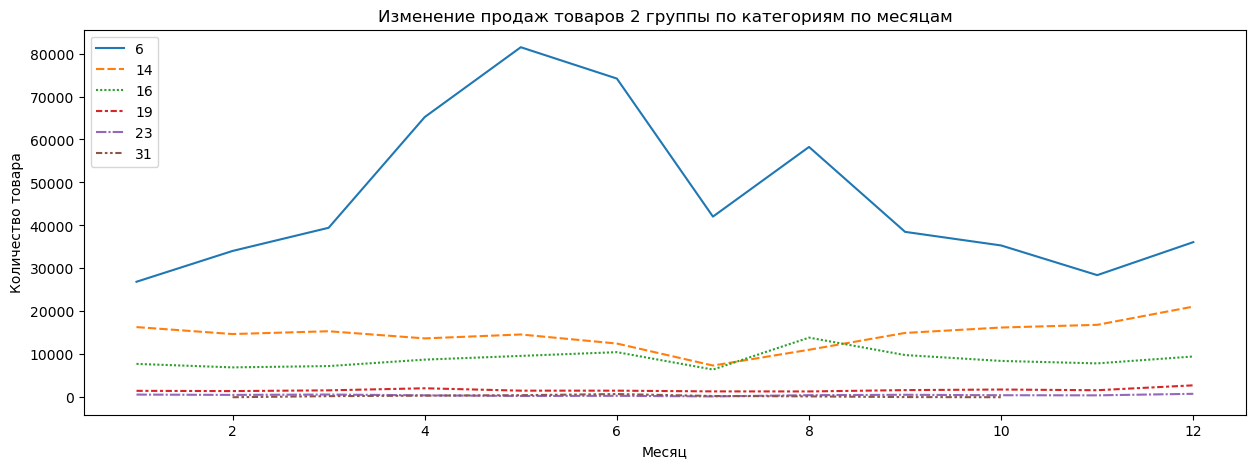

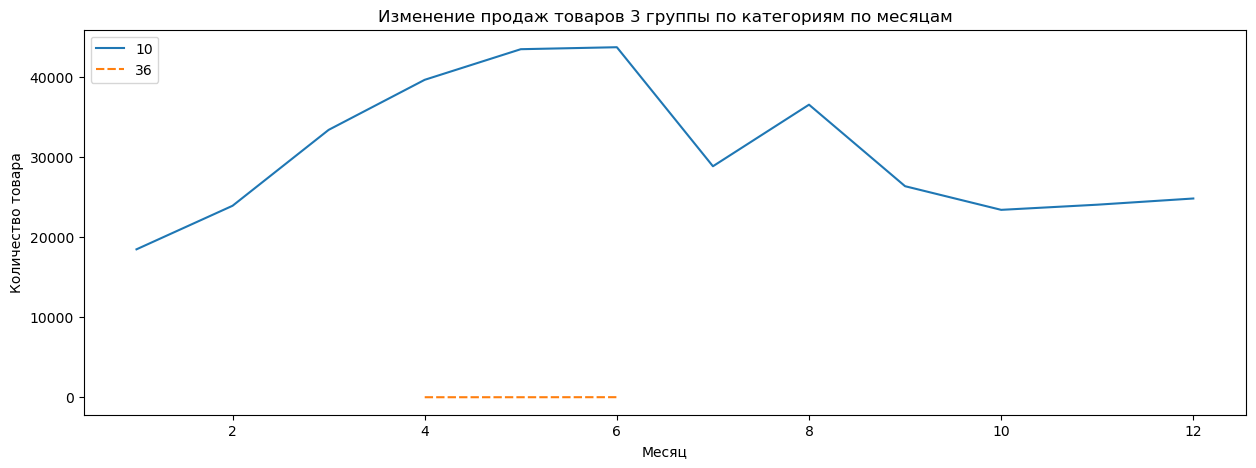

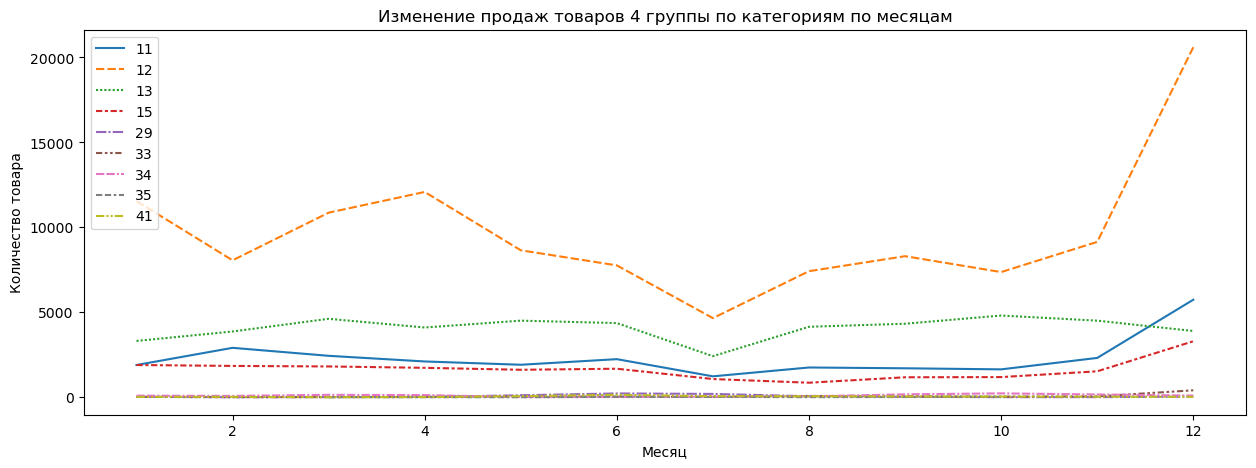

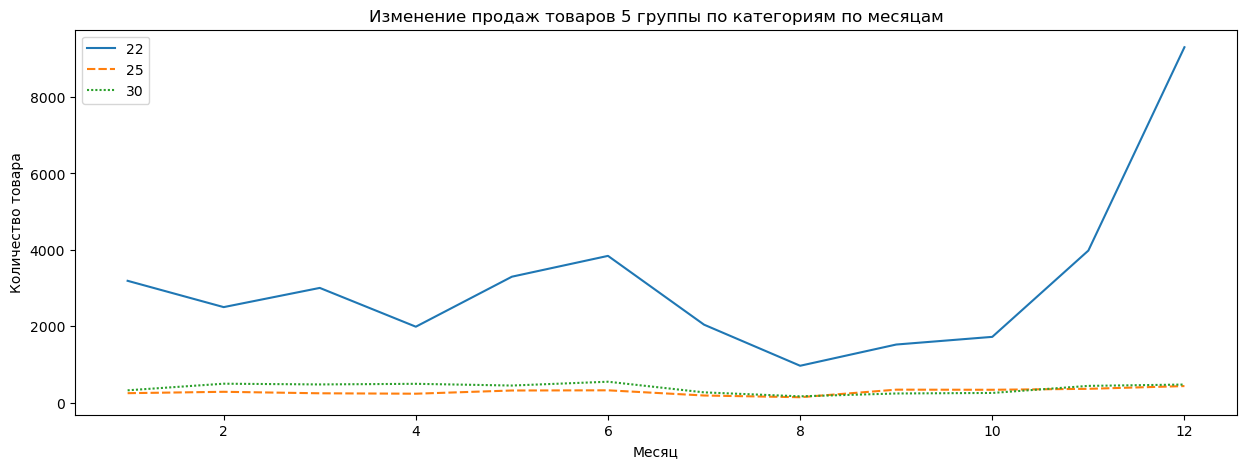

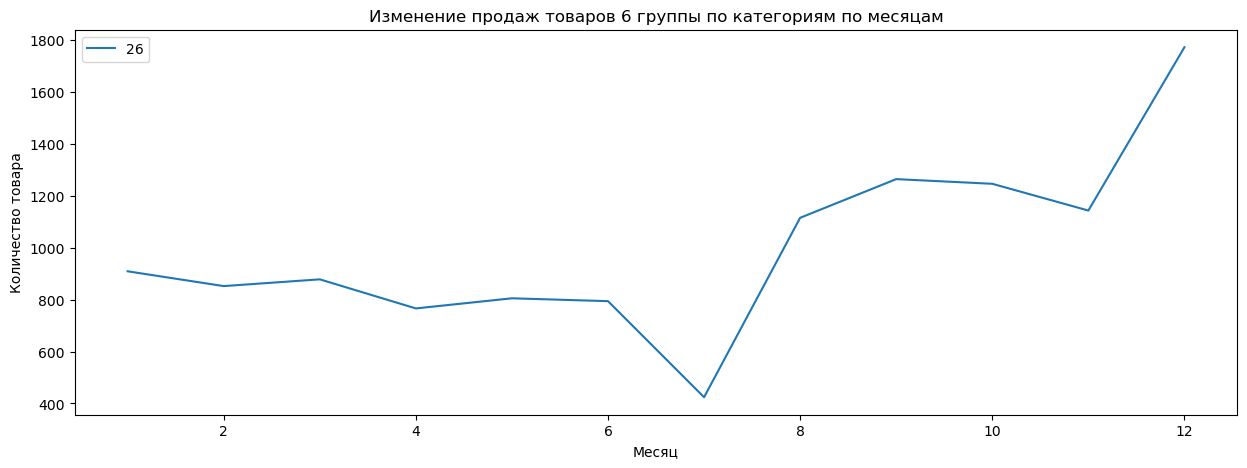

In [ ]:
# Визуализация продаж категорий товаров внутри групп во времени
name_group_id = df_num['pr_group_id'].unique()

for name in name_group_id:
    plot_cat_sales(df_num, name,  'date', 'pr_group_id', 'pr_cat_id', 'pr_sales_in_units')


На графике 3 группы товаров странное отображение товаров категории 36. Категория 36 продавалась с апреля по июнь. Сделаем срез по этой категории и посмотрим, на продажи этих товаров.

In [ ]:
df_num.query('pr_cat_id == 36')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price
172342,0,910,2023-06-06,0,1.0,0.0,115.0,0.0,3,36,118,1,0,0,1,1,8,115.00
172343,0,910,2023-05-01,0,1.0,0.0,113.0,0.0,3,36,118,1,0,0,1,1,8,113.00
172344,0,910,2023-06-23,0,1.0,0.0,252.0,0.0,3,36,118,1,0,0,1,1,8,252.00
172345,0,910,2023-06-03,0,1.0,0.0,115.0,0.0,3,36,118,1,0,0,1,1,8,115.00
172346,0,910,2023-05-26,0,2.0,0.0,338.0,0.0,3,36,118,1,0,0,1,1,8,169.00
172347,0,910,2023-06-24,0,1.0,0.0,252.0,0.0,3,36,118,1,0,0,1,1,8,252.00
172348,0,910,2023-04-28,0,1.0,0.0,111.0,0.0,3,36,118,1,0,0,1,1,8,111.00
172349,0,910,2023-05-24,0,1.0,0.0,225.0,0.0,3,36,118,1,0,0,1,1,8,225.00
172350,0,910,2023-05-07,1,1.0,1.0,97.0,97.0,3,36,118,1,0,0,1,1,8,97.00
172351,0,910,2023-04-29,0,1.0,0.0,113.0,0.0,3,36,118,1,0,0,1,1,8,113.00


Товары категории 36 присутствуют в минимальном количестве. Судя по датами эта новая категория, которую ввели в ассортимент совсем недавно.

Построим график кол-ва проданных, скользящего среднего и стандартного отклонения.

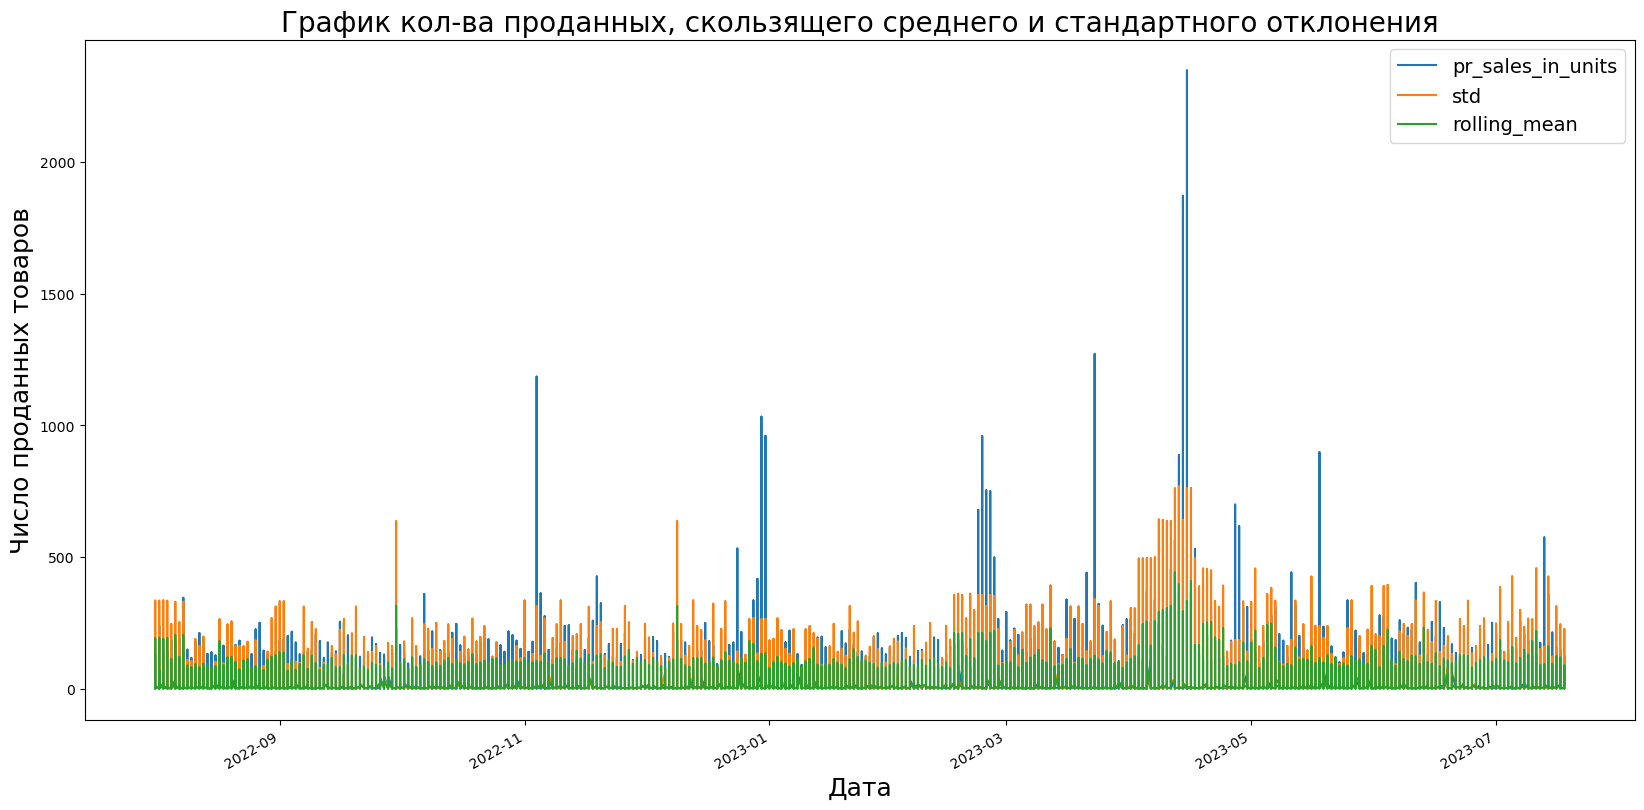

In [ ]:
units_mean_std = df_num.copy()

units_mean_std['rolling_mean'] = units_mean_std['pr_sales_in_units'].rolling(14).mean()
units_mean_std['std'] = units_mean_std['pr_sales_in_units'].rolling(14).std()

ax = units_mean_std[['date', 'pr_sales_in_units', 'std', 'rolling_mean']].plot(figsize=(20, 10),
                                                                              x='date')

ax.set_title('График кол-ва проданных, скользящего среднего и стандартного отклонения', fontsize=20)
ax.set_xlabel('Дата', fontsize=18)
ax.set_ylabel('Число проданных товаров', fontsize=18)
ax.legend(fontsize=14)
plt.show()


На графике видно, что есть сильные всплески в период с марта по май. Тут самое большое количество проданных товаров. Одним вариантом обьяснения такого всплеска может быть праздник (Пасха, 1 мая, 9 мая).  

Также присутствуют всплески в ноябре и в период с декабря по март. Но не очень большие по сравнению со всплеском в период с марта по май.


Построим матрицу корреляции данных.

In [ ]:
phik_overview = df_num.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['st_id', 'pr_sku_id', 'pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'price']


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price
st_id,1.00,0.56,0.07,0.08,0.00,0.00,0.02,0.02,0.17,0.14,0.19,0.23,1.00,1.00,1.00,1.00,0.94,0.07
pr_sku_id,0.56,1.00,0.07,0.08,0.02,0.02,0.02,0.02,0.25,0.33,0.50,0.17,0.48,0.63,0.69,0.51,0.73,0.08
date,0.07,0.07,1.00,0.11,0.05,0.05,0.05,0.04,0.06,0.04,0.05,0.04,0.07,0.07,0.08,0.06,0.07,0.03
pr_sales_type_id,0.08,0.08,0.11,1.00,0.01,0.02,0.03,0.04,0.17,0.16,0.11,0.08,0.10,0.06,0.03,0.03,0.04,0.05
pr_sales_in_units,0.00,0.02,0.05,0.01,1.00,1.00,0.58,0.57,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pr_promo_sales_in_units,0.00,0.02,0.05,0.02,1.00,1.00,0.58,0.60,0.01,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pr_sales_in_rub,0.02,0.02,0.05,0.03,0.58,0.58,1.00,1.00,0.05,0.04,0.03,0.02,0.02,0.02,0.01,0.03,0.01,0.08
pr_promo_sales_in_rub,0.02,0.02,0.04,0.04,0.57,0.60,1.00,1.00,0.05,0.04,0.03,0.02,0.02,0.01,0.01,0.03,0.01,0.07
pr_group_id,0.17,0.25,0.06,0.17,0.01,0.01,0.05,0.05,1.00,0.81,0.61,0.61,0.15,0.15,0.17,0.13,0.14,0.33
pr_cat_id,0.14,0.33,0.04,0.16,0.00,0.01,0.04,0.04,0.81,1.00,0.80,0.65,0.12,0.16,0.17,0.11,0.18,0.21


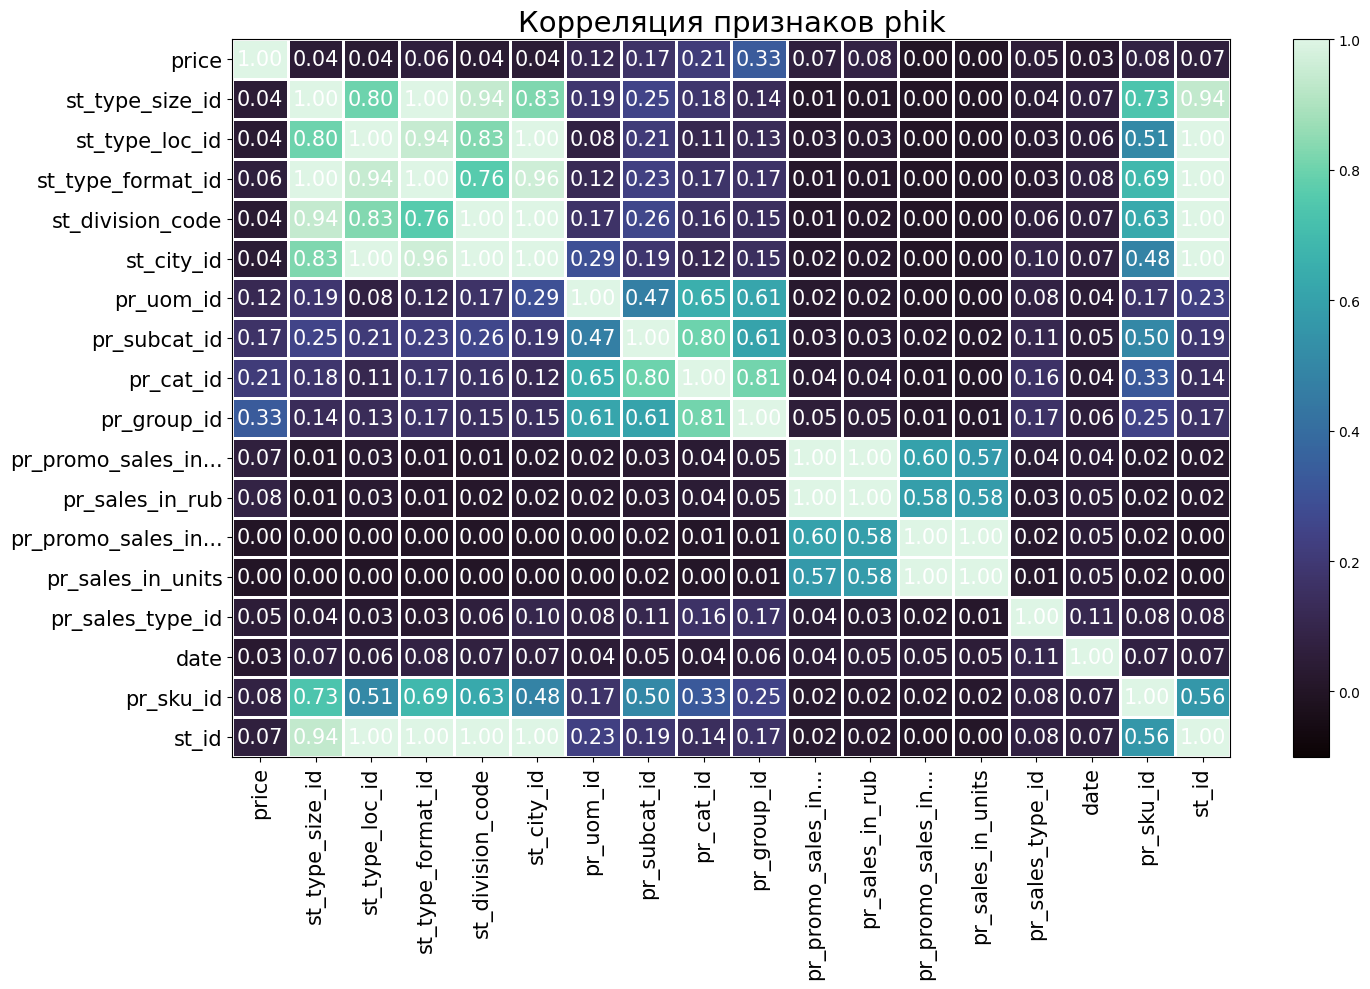

In [ ]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=1, vmax=0, color_map='mako',
                        title=r'Корреляция признаков phik',
                        fontsize_factor=1.5,
                        figsize=(15, 10))
plt.tight_layout()

На матрице корреляции видна сильная взаимосвязь некоторых признаков друг с другой. Например, взаимосвязь номера магазина с размером, типом локации, форматом магазина и т.д.

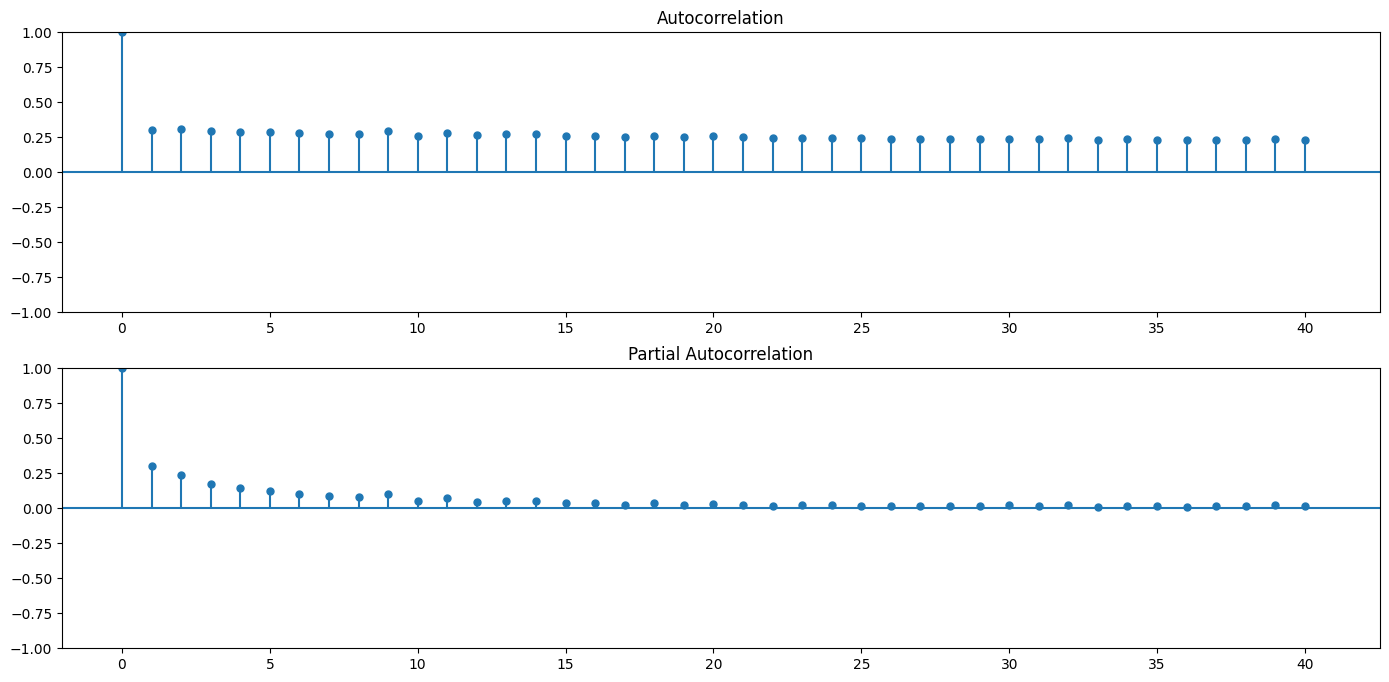

In [ ]:
# Построим графики ACF и PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 8))
plot_acf(df_plot['pr_sales_in_units'], ax=ax1, lags=40)
plot_pacf(df_plot['pr_sales_in_units'], ax=ax2, lags=40)
plt.show()

Лаги, которые следует рассмотреть - это 1,2,3,4,9. Размер окна для скользящего среднего определим 9.

In [ ]:
del sales_df_train
del pr_df
del st_df


In [ ]:
del units_mean_std
del pivot_table
del df_plot
del df_a
del df
del df_grouped
del phik_overview

**Вывод:**


При изучении общего распределения данных было выявлено следующее:


1. При исследовании групп товаров можно выделить топ-3:
   * Группа №1 - 44,8%
   * Группа №0 - 32,39%
   * Группа №2 - 10.94%
2. В нашем распоряжении данные 12 магазинов из 7 городов. Очень мало данных о магазинах с номером 7, 9, 10 и 11. Продажи этих магазинов составляют менее 1% от общего объёма данных.
3. Среди категорий товара также можно выделить ТОП наиболее продаваемых категорий:
   * Категория №4 - 21.02%
   * Категория №3 - 12.26%
   * Категория №0 - 11.23%
   * Категория №8 - 10.49%
4. В столбце st_is_active представлена о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никакой смысловой информации для нас.
5. Товары группы 7 и 8 катастрофически малы, поэтому эти группы были исключены из анализа.
6. Также в данных присутствовала информация о товарах с нулевым количество продаж и не нулевой суммой продаж. Эти данные были исключены. А вот данные с нулевыми суммами продаж были заполнены произведением среднего значения цены для каждой позиции товара на количество проданных товаров.
7. Был создан столбец со стоимостью товар за штуку.


При изучении информации по каждому магазину в отдельности было выявлено следующее:


1. У большинства магазинов есть свои уникальные товары, которые продаются, только в их магазине. Исключением из этого являются магазины 2 и 6. В этих магазинах нет уникальных товаров, характерных только для этих магазинов.
2. Магазин с id 10 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся.
3. Магазин с id 7 имеет крайне странные продажи (ровно 1 месяц). Объём таких продаж крайне мал.
4. Магазин с id 11 осуществлял продажи только в период с 24 августа по 8 сентября, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции.
5. Исключили информацию из данных о магазинах с id 7, 11, поскольку информации о продажах данных магазинов была крайне мала и не информативна.


При изучении информации распределения продаж во времени обнаружено следующее:


1. В конце декабря, в конце февраля – начале марта, апрель – май имеются высокие всплески продаж. Это скорее всего связано с праздниками (Новый год, 23 февраля, 8 марта, масленица, пасха, 1 мая, 9 мая)
2. В январе - феврале имеется сильное падение продаж. Это объяснимо тем, что люди разъехались за город или закупили достаточно продуктов перед новым годом, а также в целом снижением затрат населения на покупку продуктов после праздников.
3. Было обнаружено, что товар с категорий 24 продавался только с апреля по июнь и в минимальном количестве. Эту категорию исключили, поскольку данных недостаточно для прогнозирования.



# Feature engineering

### Создание календаря праздиков в качестве признака.

Созданим новые признаки. Создадим признак указывающий, является ли день праздником или нет. Данные о праздиках содержится в датафрейме holidays_covid_calendar.

In [ ]:
holidays_covid_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [ ]:
holidays_covid_calendar['date'] = pd.to_datetime(holidays_covid_calendar['date'], format="%d.%m.%Y", infer_datetime_format=True)

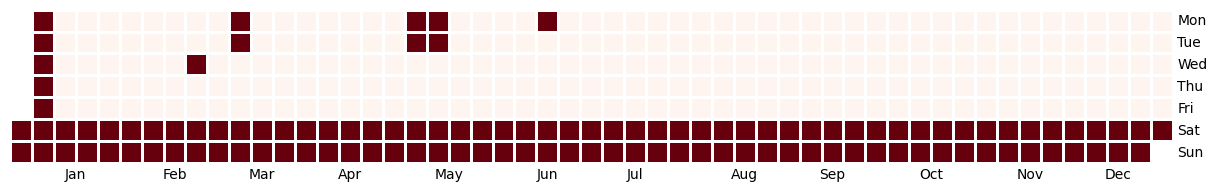

In [ ]:
# Построим тепловую карту-календарь
hol = pd.DataFrame(list(holidays_covid_calendar['holiday']), index=holidays_covid_calendar['date'])
plt.figure(figsize=(15, 15))
calmap.yearplot(hol, year=2022);

In [ ]:
# Объединение датафреймов, удалиние лишних столбцов
df_num = pd.merge(df_num, holidays_covid_calendar, on='date').drop(['year', 'day', 'weekday', 'calday','covid'], axis=1)

In [ ]:
df_num.sample(5)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price,holiday
636173,1,464,2022-11-13,1,1.0,1.0,147.0,147.0,2,16,61,1,1,1,1,1,12,147.00,1
403678,3,92,2023-04-28,0,1.0,0.0,372.0,0.0,0,9,30,1,3,3,1,1,12,372.00,0
106466,2,154,2023-03-22,1,61.0,61.0,1656.0,1656.0,1,4,8,17,2,2,1,2,8,27.15,0
200675,3,897,2023-04-08,1,5.0,5.0,265.0,265.0,1,3,66,17,3,3,1,1,12,53.00,1
143980,1,395,2022-10-14,1,1.0,1.0,87.0,87.0,0,7,13,17,1,1,1,1,12,87.00,0


### Создание дополнительных лаговых и временных признаков

По заданию необходимо дать прогноз на 14 дней, поэтому все признаки сдвигаем минимум на 14 дней вперед во избежание утечки таргета.

* units_lag_14, units_lag_15, units_lag_16, units_lag_17, units_lag_23, units_las_lag_28 - продажи в штуках с лагами 14, 15, 16, 17, 23, 28


* units_mean_9 - скользящее среднее продаж в штуках за 9 дней с лагом 14


* units_cat_lag14 - продажи в штуках с лагом 14 с группировкой по категориям товаров.
* rub_cat_lag14 - продажи в рублях с лагом 14 с группировкой по категориям товаров.

* units_cat_max_lag14 - максисмальная сумма продаж в штуках за 14 дней с лагом 14 с группировкой по категориям товаров.
* units_cat_min_lag14 - минимальная сумма продаж в штуках за 14 дней с лагом 14 с группировкой по категориям товаров.
* units_cat_mean14_lag14 - скользящее среднее продаж в штуках за 14 дней с лагом 14 с группировкой по категориям товаров.
* units_cat_mean9_lag14 - скользящее среднее продаж в штуках за 9 дней с лагом 14 с группировкой по категориям товаров.

* rub_cat_max_lag14 - максисмальная сумма продаж в рублях за 14 дней с лагом 14с группировкой по категориям товаров.
* rub_cat_min_lag14 - минимальная сумма продаж в рублях за 14 дней с лагом 14 с группировкой по категориям товаров.
* rub_cat_mean14_lag14 - скользящее среднее продаж в рублях за 14 дней с лагом 14 с группировкой по категориям товаров.
* rub_cat_mean9_lag14 - скользящее среднее продаж в рублях за 9 дней с лагом 14 с группировкой по категориям товаров.

* units_mean9_cat_sku - скользящее среднее продаж за последние 9 дней с лагом 14 с группировкой по категориям товаров и товарным позициям (sku).

* units_city_lag14 - продажи в штуках с лагом 14 с группировкой по городам.
* rub_city_lag14 - продажи в рублях с лагом 14 с группировкой по городам.

* units_loc_type_lag14 - продажи в штуках с лагом 14 с группировкой по типу локации.
* rub_loc_type_lag14 - продажи в рублях с лагом 14 с группировкой по типу локации.

* units_st_sku_lag_14, units_st_sku_lag_15, units_st_sku_lag_16, units_st_sku_lag_17, units_st_sku_lag_23, units_st_sku_las_lag_28 - продажи в штуках с лагами 14, 15, 16, 17, 23, 28

* units_st_sku_max_lag14 - максисмальная сумма продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku).
* units_st_sku_min_lag14 - минимальная сумма продаж в штуках за 14 дней с лагом 14 с группировкойпо магазинам и товарным позициям (sku).
* units_st_sku_mean14_lag14 - скользящее среднее продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku).
* units_st_sku_mean9_lag14 - скользящее среднее продаж в штуках за 9 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku).

* rub_st_sku_max_lag14 - максисмальная сумма продаж в рублях за 14 дней с лагом 14с группировкой по магазинам и товарным позициям (sku).
* rub_st_sku_min_lag14 - минимальная сумма продаж в рублях за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku).
* rub_st_sku_mean14_lag14 - скользящее среднее продаж в рублях за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku).
* rub_st_sku_mean9_lag14 - скользящее среднее продаж в рублях за 9 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku).

* day - день .
* dayofweek - день недели.
* dayofyear - день года
* week - неделя.
* month - месяц.
* quarter - квартал.


In [ ]:
def generate_features(df):
  df = df.sort_values('date', ascending=False)
  df = df.assign(
      units_lag_14 = df['pr_sales_in_units'].shift(14),
      units_lag_15 = df['pr_sales_in_units'].shift(15),
      units_lag_16 = df['pr_sales_in_units'].shift(16),
      units_lag_17 = df['pr_sales_in_units'].shift(17),
      units_lag_23 = df['pr_sales_in_units'].shift(23),
      units_lag_28 = df['pr_sales_in_units'].shift(28),

      units_mean_9 = df['pr_sales_in_units'].shift(14).rolling(9).mean(),

      units_cat_lag14 = df.groupby('pr_cat_id')['pr_sales_in_units'].shift(14),
      rub_cat_lag14 = df.groupby('pr_cat_id')['pr_sales_in_rub'].shift(14),

      units_cat_max_lag14 = df.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).max()),
      units_cat_min_lag14 = df.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).min()),
      units_cat_mean14_lag14 = df.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).mean()),
      units_cat_mean9_lag14 = df.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=9, min_periods=1).mean()),

      rub_cat_max_lag14 = df.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).max()),
      rub_cat_min_lag14 = df.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).min()),
      rub_cat_mean14_lag14 = df.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).mean()),
      rub_cat_mean9_lag14 = df.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=9, min_periods=1).mean()),

      units_mean9_cat_sku = df.groupby(['pr_cat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=9, min_periods=1).mean()),

      units_city_lag14 = df.groupby('st_city_id')['pr_sales_in_units'].shift(14),
      rub_city_lag14 = df.groupby('st_city_id')['pr_sales_in_rub'].shift(14),

      units_loc_type_lag14 = df.groupby('st_type_loc_id')['pr_sales_in_units'].shift(14),
      rub_loc_type_lag14 = df.groupby('st_type_loc_id')['pr_sales_in_rub'].shift(14),

      units_st_sku_lag_14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].shift(14),
      units_st_sku_lag_15 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].shift(15),
      units_st_sku_lag_16 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].shift(16),
      units_st_sku_lag_17 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].shift(17),
      units_st_sku_lag_23 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].shift(23),
      units_st_sku_lag_28 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].shift(28),

      units_st_sku_max_lag14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).max()),
      units_st_sku_min_lag14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).min()),
      units_st_sku_mean9 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=9, min_periods=1).mean()),
      units_st_sku_mean14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).mean()),

      rub_st_sku_max_lag14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).max()),
      rub_st_sku_min_lag14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).min()),
      rub_st_sku_mean9 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=9, min_periods=1).mean()),
      rub_st_sku_mean14_lag14 = df.groupby(['st_id', 'pr_sku_id'])['pr_sales_in_rub'].transform(lambda x: x.shift(14).rolling(window=14, min_periods=1).mean()),

      day = df['date'].dt.day,
      dayofweek = df['date'].dt.dayofweek,
      dayofyear = df['date'].dt.dayofyear,
      week = df['date'].dt.isocalendar().week.astype('int32'),
      month = df['date'].dt.month,
      quarter = df['date'].dt.quarter
    )

  df = df.dropna()
  df.set_index('date', inplace=True)

  return df

# Обучение

Прежде чем приступить к обучению разделим датасет на обучающий и тестовый в соотношении 9:1. Подбирать параметры и обучать все модели будем на обучающем. Проверять качество будем на тестовой выборке. При разделении необходимо учесть, что данные не должны перемешиваться.

In [ ]:
train, test = train_test_split(df_num, shuffle=False, test_size=.1)
train, valid = train_test_split(train, shuffle=False, test_size=.33)

print("Размер обучающей выборки: {:.0%}".format(train.shape[0] / df_num.shape[0]))
print("Размер валидационной выборки: {:.0%}".format(valid.shape[0] / df_num.shape[0]))
print("Размер тестовой выборки: {:.0%}".format(test.shape[0] / df_num.shape[0]))

Размер обучающей выборки: 60%
Размер валидационной выборки: 30%
Размер тестовой выборки: 10%


По условию для тестовой выборки необходимо оставить столбец pr_sales_type_id, при этом всем товарам, которые продавались по акции(флаг промо = 1) присвоить флаг промо = 0.

In [ ]:
test['pr_sales_type_id'] = 0

Для решения поставленной задачи обучим несколько моделей.

**Модели:**

1. CatBoostRegressor
2. LGBMRegressor
3. ElasticNet

**Метрика качества** - WAPE.

In [ ]:
# Парметры моделей и pipeline

catboost_params = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'iterations': [1000, 1500]
}

lgbm_params = {
    'LGBMRegressor__learning_rate': [0.01, 0.05, 0.1],
    'LGBMRegressor__max_depth': [5, 10, 15],
    'LGBMRegressor__verbosity': [-1],
    'LGBMRegressor__num_leaves': [50, 80],
    'LGBMRegressor__min_child_samples': [20, 30, 50]
}

elastic_params = {
    'elastic__alpha': np.linspace(0.1, 1.0, 10),
    'elastic__l1_ratio': np.linspace(0.1, 1.0, 10)
}

catboost = CatBoostRegressor(verbose = False, task_type='GPU')


lgbm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('LGBMRegressor', LGBMRegressor())
])

elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet())
])

# Создание метрики WAPE в качестве scorer
scorer = make_scorer(wape, greater_is_better=False)

# Создание списков моделей и их параметров
models = [catboost, lgbm_pipeline, elastic_pipeline]
params = [catboost_params, lgbm_params, elastic_params]
model_names = [CatBoostRegressor, LGBMRegressor,  ElasticNet]

num_folds = 5

Подбор параметров осуществялется с помощью GridSearch. Для перекресной проверки используется TimeSeriesSplit, поскольку он подходит для работы с временными рядами. Это будет происходит в цикле, в котором для каждой выборки будут генерироваться дополнительные признаки, чтобы оптимизировать процесс.

In [ ]:
import gc

tscv = TimeSeriesSplit(n_splits=num_folds)
all_models = []  # список для хранения лучших моделей на каждом уровне
train_size_increment = len(train) // num_folds
max_train_size = train_size_increment

for model, pars, name in zip(models, params, model_names):
    model_name = name

    print(f'Модель: {model_name}')

    best_model = None
    best_score = float('inf')

    for train_index, val_index in tscv.split(train):
        train_slice = train.iloc[train_index[:max_train_size]]
        new_df_slice_train = generate_features(train_slice)
        features_slice_train = new_df_slice_train.drop(['pr_sales_in_units', 'pr_promo_sales_in_units','pr_sales_in_rub', 'pr_promo_sales_in_rub'], axis=1)
        target_slice_train = new_df_slice_train['pr_sales_in_units']


        val_slice = train.iloc[val_index]
        new_df_slice_val = generate_features(val_slice)
        features_slice_val = new_df_slice_val.drop(['pr_sales_in_units', 'pr_promo_sales_in_units','pr_sales_in_rub', 'pr_promo_sales_in_rub'], axis=1)
        target_slice_val = new_df_slice_val['pr_sales_in_units']


        grid_search = GridSearchCV(model, pars, scoring=scorer, cv=tscv)

        with tqdm(total=100, desc='Grid Search') as pbar1:
            grid_search.fit(features_slice_train, target_slice_train)
            best_model = grid_search.best_estimator_
            pbar1.update(100)

        # Оценка производительности модели на валидационном срезе
        with tqdm(total=100, desc='Прогнозирование') as pbar2:
            y_pred_val = best_model.predict(features_slice_val)
            val_score = wape(target_slice_val, y_pred_val)
            pbar2.update(100)


        # Сохранение лучшей модели на текущем срезе данных
        if val_score < best_score:
            best_score = val_score
            best_model = best_model

        max_train_size += train_size_increment

        del train_slice, new_df_slice_train, features_slice_train, target_slice_train
        del val_slice, new_df_slice_val, features_slice_val, target_slice_val
        gc.collect()

    all_models.append(best_model)

    del best_model
    gc.collect()

    print(f"WAPE для модели: {model_name}: {best_score}")

Модель: <class 'catboost.core.CatBoostRegressor'>


Прогнозирование: 100%|██████████| 100/100 [00:00<00:00, 627.76it/s]


WAPE для модели: <class 'catboost.core.CatBoostRegressor'>: 0.5617000361231724
Модель: <class 'lightgbm.sklearn.LGBMRegressor'>


Прогнозирование: 100%|██████████| 100/100 [00:00<00:00, 862.95it/s]


WAPE для модели: <class 'lightgbm.sklearn.LGBMRegressor'>: 0.5736984317956098
Модель: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>


Прогнозирование: 100%|██████████| 100/100 [00:00<00:00, 9152.27it/s]


WAPE для модели: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 0.6823085277310317


In [ ]:
meta_dict = {
    'CatBoostRegressor': all_models[0],
    'LGBMRegressor': all_models[1],
    'ElasticNet': all_models[2]
}

In [ ]:
# Сохранение моделей
for name, model in meta_dict.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

### Оценка важности признаков

Посмотрим на важность признаков для каждой из модели первого уровня.

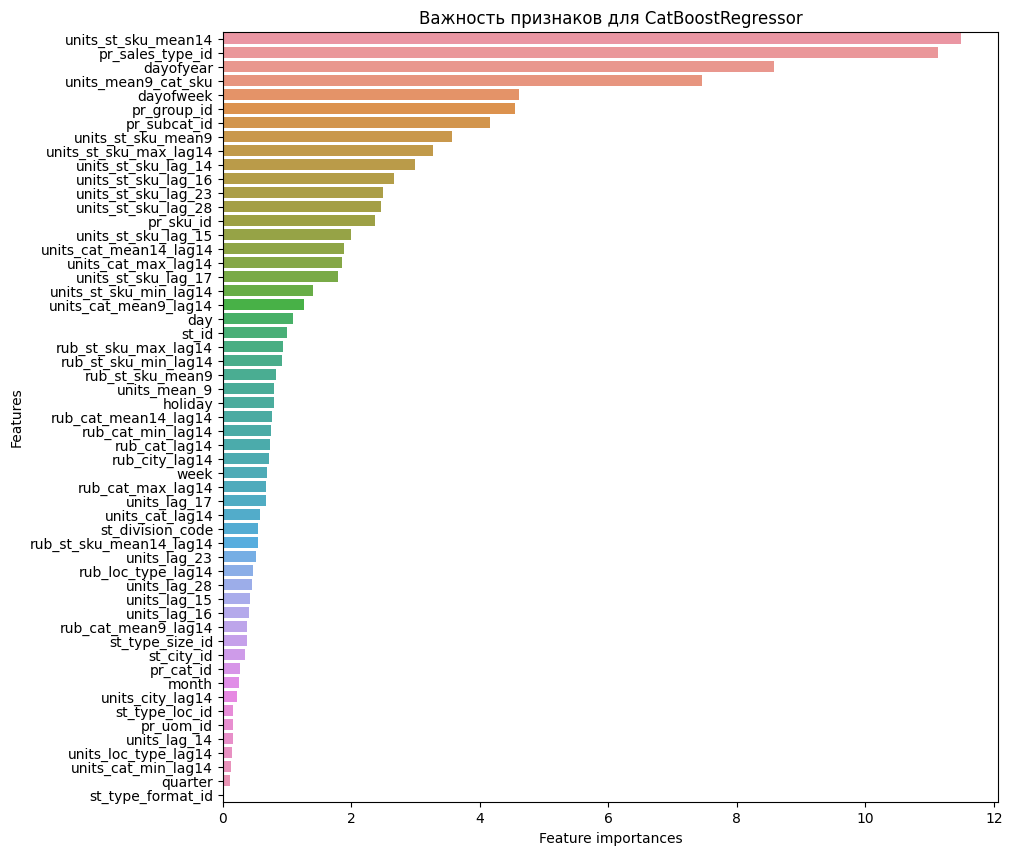

In [ ]:
# Посмотрим на важность признаков для CatBoostRegressor

cb_feat_imp = all_models[0].get_feature_importance(prettified=True)

plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=cb_feat_imp['Importances'], y=cb_feat_imp['Feature Id'])
ax.set_title('Важность признаков для CatBoostRegressor')
ax.set_yticklabels(cb_feat_imp['Feature Id'])
ax.set_xlabel('Feature importances')
ax.set_ylabel('Features')
plt.show()

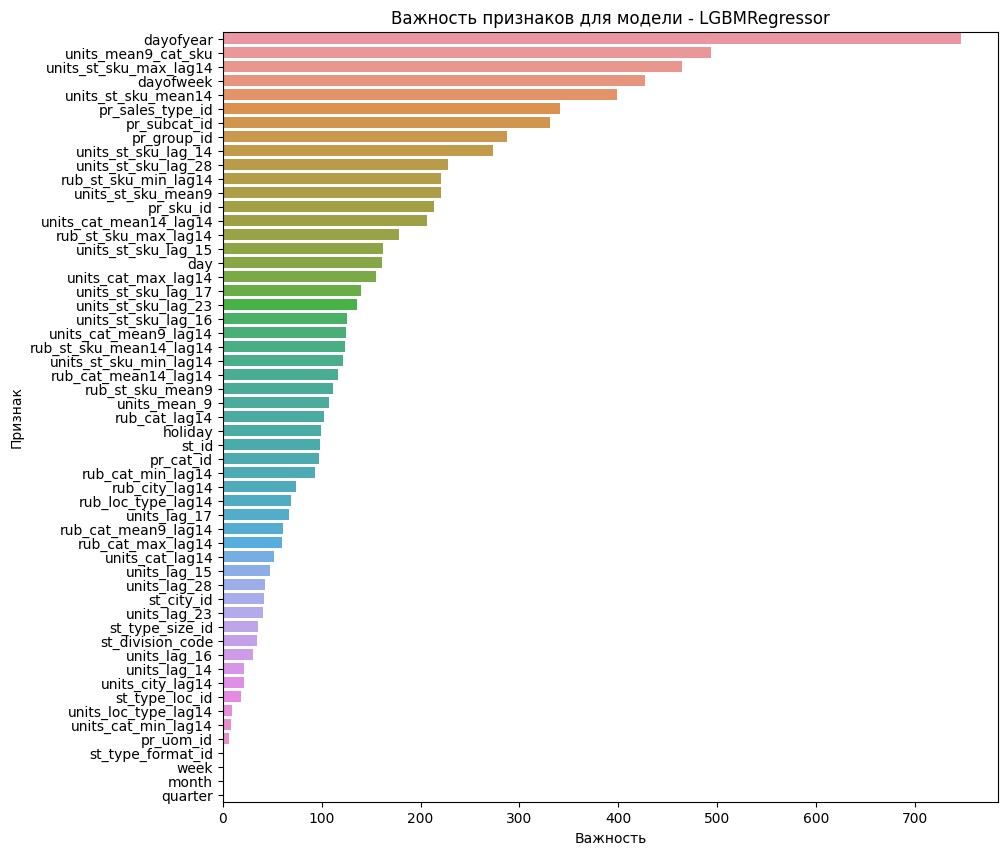

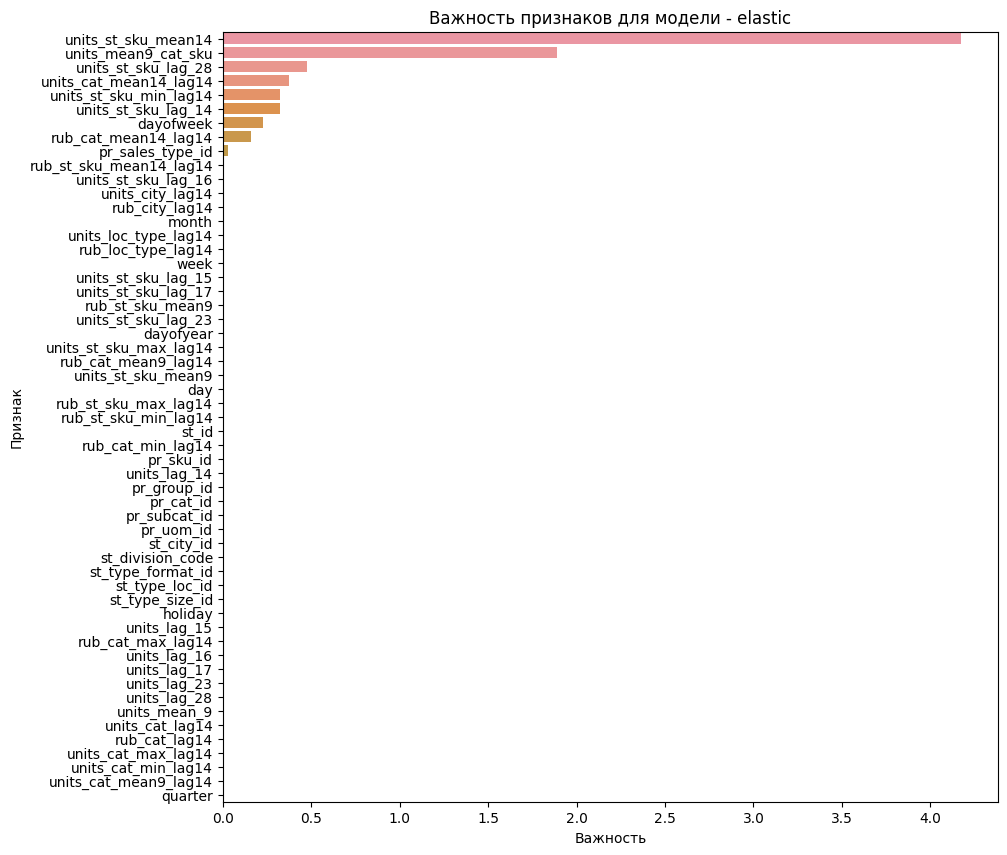

0

In [ ]:
# Посмотрим на важность признаков LGBMRegressor и ElasticNet
feature_importances = []
for pipeline in all_models[1:3]:
    model_name = pipeline.steps[-1][0]
    model = pipeline.steps[-1][1]
    importances = None

    if hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    feature_importances.append((model_name, importances))


for model_name, importances in feature_importances:
    if importances is not None:
        importance_df = pd.DataFrame({'Признак': feature_names, 'Важность': importances})
        importance_df = importance_df.sort_values(by='Важность', ascending=False)
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Важность', y='Признак', data=importance_df)
        plt.title(f'Важность признаков для модели - {model_name}')
        plt.show()

        # Удаление ненужных объектов
    del importance_df
    gc.collect()

# Удаление ненужных объектов
del feature_importances
gc.collect()

**Вывод:**

1. Модель CatBoostRegressor

 Самые важные признаки units_st_sku_mean14 - скользящее среднее продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku) и pr_sales_type_id(флаг наличия промо). В меньшей степени модель ориентируется на dayofyear(день года) и units_mean9_cat_sku (скользящее среднее продаж за последние 9 дней с лагом 14 с группировкой по категориям товаров и товарным позициям (sku)).

2. Модель LGBMRegressor

  Самым важным признаком с большим отрывом оказался dayofyear(день года). Менее значимые признаки: units_mean9_cat_sku (скользящее среднее продаж за последние 9 дней с лагом 14 с группировкой по категориям товаров и товарным позициям (sku)) и units_st_sku_max_lag14 (максисмальная сумма продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku)), dayofweek (день недели), units_st_sku_mean14_lag14 (скользящее среднее продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku)).

3. Модель ElasticNet

    Учитывает значительно меньше признаков для прогнозирования, чем предыдущие модели. На первом месте с большим отрывом как и у CatBoostRegressor - units_st_sku_mean14 (скользящее среднее продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям (sku)). На втором месте как у LGBMRegressor - units_mean9_cat_sku (скользящее среднее продаж за последние 9 дней с лагом 14 с группировкой по категориям товаров и товарным позициям (sku)).

             
В целом самым важным признаком для двух из трех моделей оказалось скользящее среднее продаж в штуках за 14 дней с лагом 14 с группировкой по магазинам и товарным позициям. На втором месте -  скользящее среднее продаж за последние 9 дней с лагом 14 с группировкой по категориям товаров и товарным позициям. Для моделей градиентного бустнига, помимо скользящих средних, важны день недели и день года. В целом бустинги в отличие от линейной модели учитывают большинство признаков.

### Тестирование

In [ ]:
# Протестиуем лучшую модель
test = generate_features(test)
features_test = test.drop(['pr_sales_in_units', 'pr_promo_sales_in_units','pr_sales_in_rub', 'pr_promo_sales_in_rub'], axis=1)
target_test = test['pr_sales_in_units']
catboost_predict_test = all_models[0].predict(features_test)
wape_test = wape(target_test, catboost_predict_test)

print('WAPE для модели CatBoostRegressor на тесте:', wape_test)

WAPE для модели на тесте: 0.7174182259343117


**Вывод:**

 Метрика на тестовой выборке с заменненым флагом промо на 0 для всех позиций оказалась выше по сравнению с метрикой на валидационной выборке.

### Сохранение результатов прогнозирования и моделей.

In [ ]:
predict_df = pd.DataFrame(catboost_predict_test, columns=['target'])
predict_df = round(predict_df)
features_test.reset_index(inplace= True)

df_predictions = pd.DataFrame({'st_id': features_test['st_id'],
                               'pr_sku_id': features_test['pr_sku_id'],
                               'date': features_test['date']})

# Замена порядковых номеров на исходные значения хэшей
df_predictions['st_id'] = df_predictions['st_id'].map(num_to_hash_dict['st_id'])
df_predictions['pr_sku_id'] = df_predictions['pr_sku_id'].map(num_to_hash_dict['pr_sku_id'])

# Создание датафрейма с исходными значениями и предсказаниями
sales_submission = pd.concat([df_predictions[['st_id', 'pr_sku_id', 'date']], predict_df], axis=1)


sales_submission.to_csv('sales_submission.csv', index=False)

### Анализ остатков

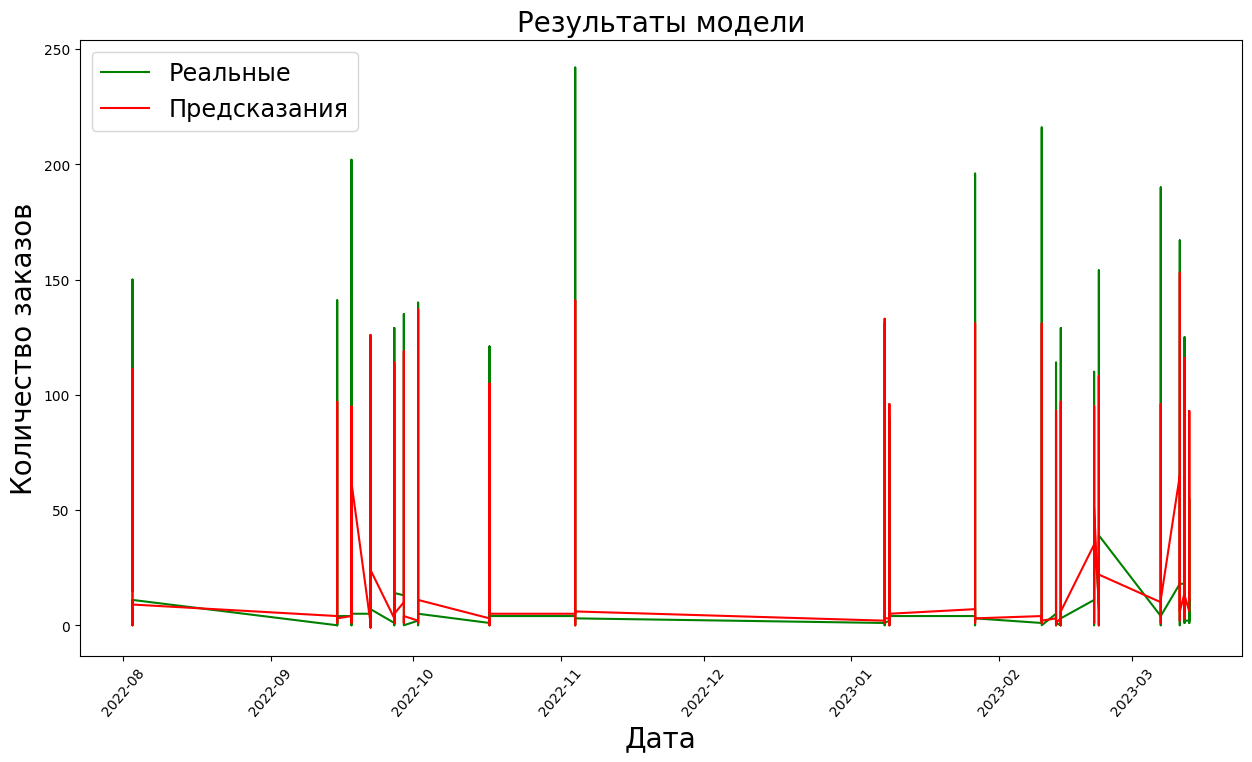

In [ ]:
plt.figure(figsize=(15, 8))

plt.plot(target_test.index, target_test, 'g-', label='Реальные')
plt.plot(target_test.index, predict_df,'r-', label='Предсказания')

plt.legend(fontsize='xx-large')
plt.title('Результаты модели', fontsize=20)
plt.ylabel('Количество заказов', fontsize=20)
plt.xlabel('Дата', fontsize=20)
plt.xticks(rotation=50)
plt.show()

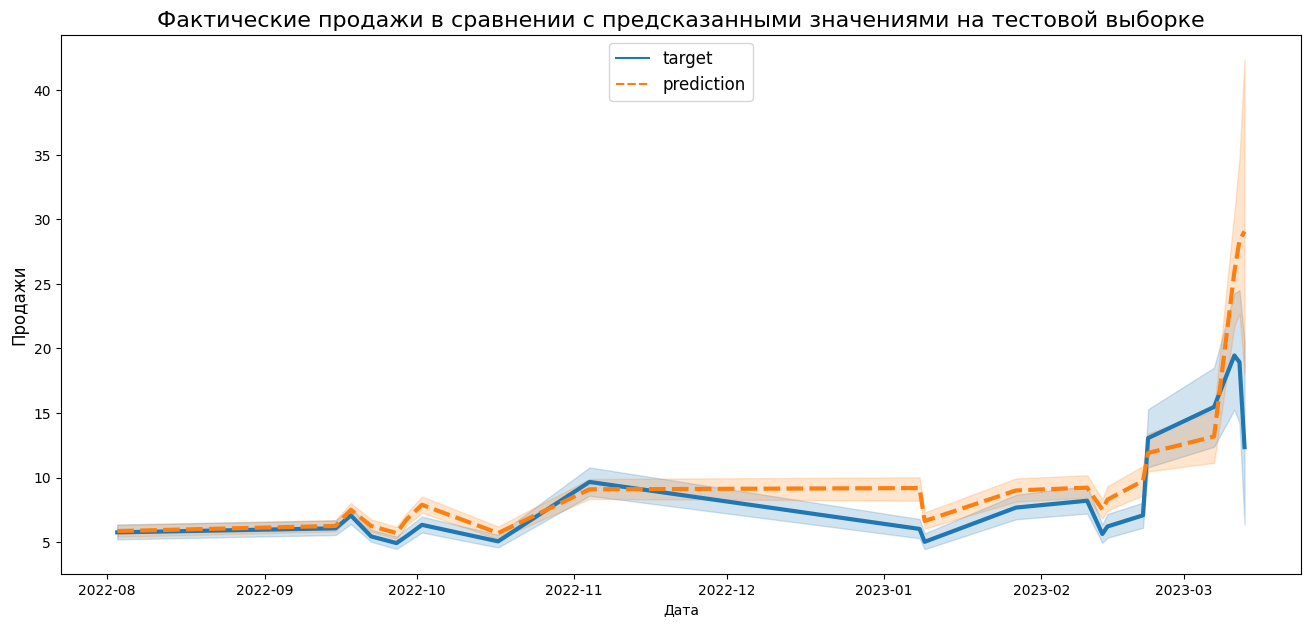

In [ ]:
target_df_test = target_test.squeeze()
catboost_predict_test = catboost_predict_test.squeeze()


# Объединяем истинные значения и предсказания в один DataFrame
df_pred = pd.DataFrame({
    'target': target_test,
    'prediction': catboost_predict_test
})

# Визуализируем результаты
fig, ax = plt.subplots(figsize=(16,7))
sns.lineplot(data=df_pred[['target', 'prediction']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Фактические продажи в сравнении с предсказанными значениями на тестовой выборке', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Продажи', fontsize=12)
plt.show()

Проведем остаточный анализ для прогнозов.

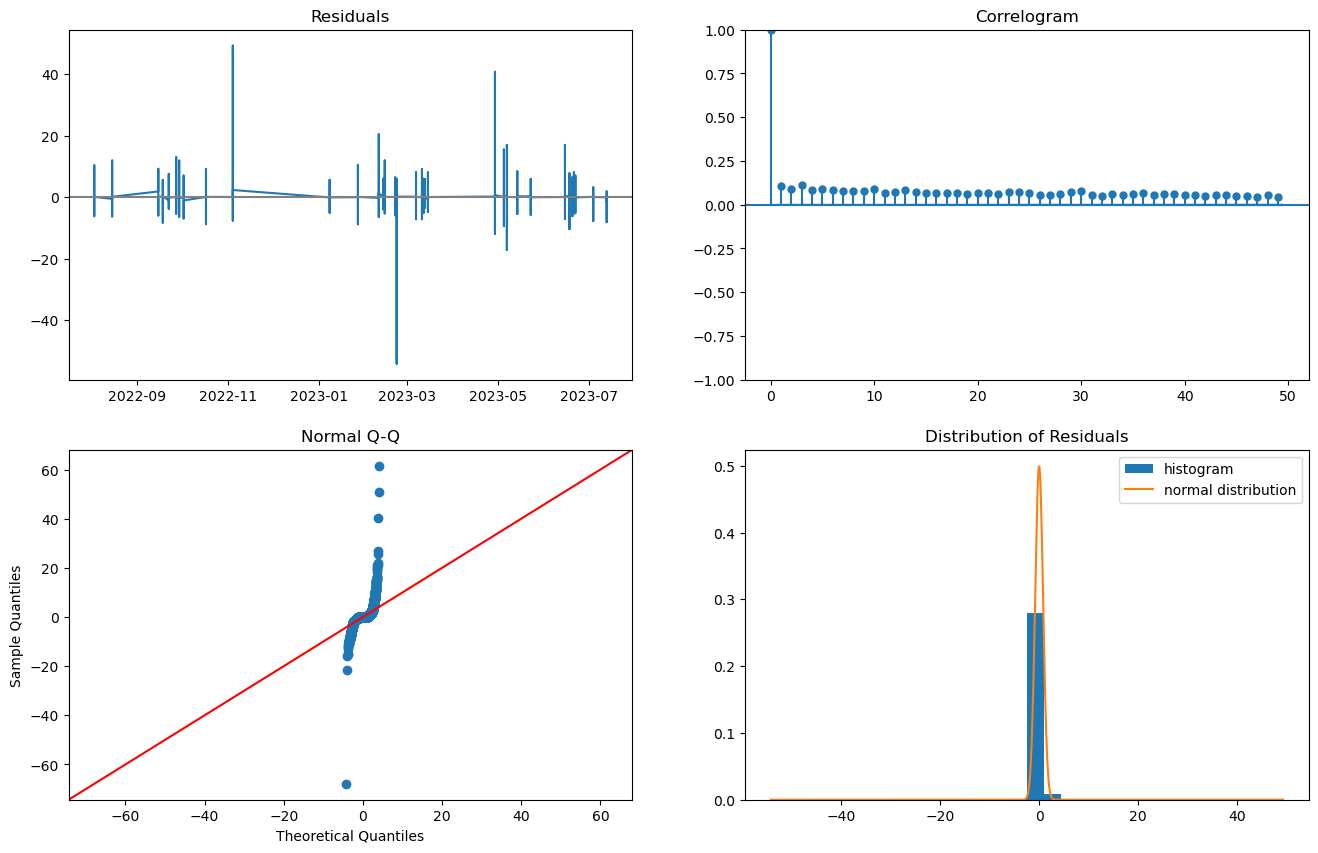

In [ ]:
residual_plot(df_pred)

Проведем проверку модели на адекватность, сравнив со средним значением.

In [ ]:
predicted_mean = np.ones(features_test.shape[0])*target_df_test.mean()
wape_mean = wape(target_test, predicted_mean)
print('WAPE по среднему значению :', wape_mean)

WAPE по среднему значению : 0.9590210243491579


Значение метрики на тесте в сравнении с метрикой по среднему значению  ниже, поэтому можно утвержать, что наша модель адекватна.